# Forecast output exploration
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

This notebook generates visual analyses of the generated forecast for a specified model.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.forecast-output','true')

In [3]:
model_name = "mlp"

In [4]:
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
with open(os.path.join(aml_dir, model_name + '_predictions.pkl'), 'rb') as f:
    predictions = pickle.load(f)

In [5]:
for n in range(1, 7):    
    predictions['error_t+'+str(n)] = predictions['pred_t+'+str(n)] - predictions['demand']
    predictions['abs_error_t+'+str(n)] = abs(predictions['error_t+'+str(n)])
    predictions['abs_pct_error_t+'+str(n)] = abs(predictions['error_t+'+str(n)]) / predictions['demand']

### Inspect forecast for a specified date range

Set date range for forecast inspection. The test dataset covers the date range 2016-07-01 to 2017-08-10.

In [6]:
min_date = '2016-07-01'
max_date = '2016-07-07'

The chart below shows the actual demand and forecasts over the specified period. Multiple forecasts for the same period are shown. For example, forecast $t+3$ represents the prediction made 3 hours before the period being forecasted.

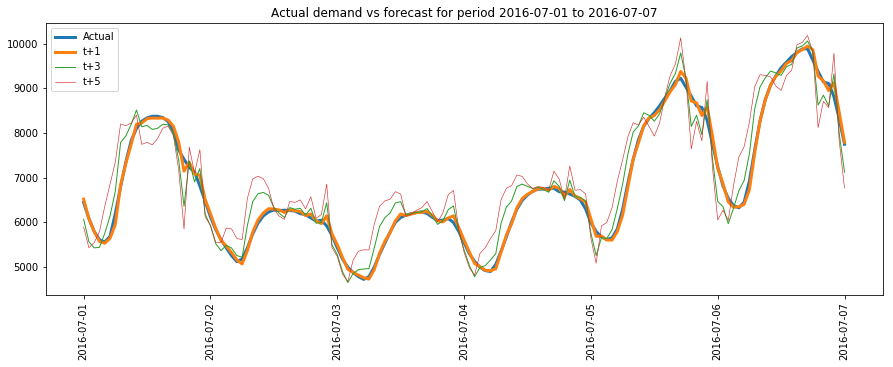

In [7]:
plot_df = predictions.loc[(predictions['timeStamp']>=min_date) & (predictions['timeStamp']<=max_date), ]
plt.figure(figsize=(15, 5))
plt.plot(plot_df['timeStamp'], plot_df['demand'], linewidth=3, label='Actual')
for n in [1,3,5]:
    plt.plot(plot_df['timeStamp'], plot_df['pred_t+'+str(n)], linewidth=3/n, label='t+'+str(n))
plt.xticks(rotation=90)
plt.title('Actual demand vs forecast for period ' + min_date + ' to ' + max_date)
plt.legend()
plt.show()

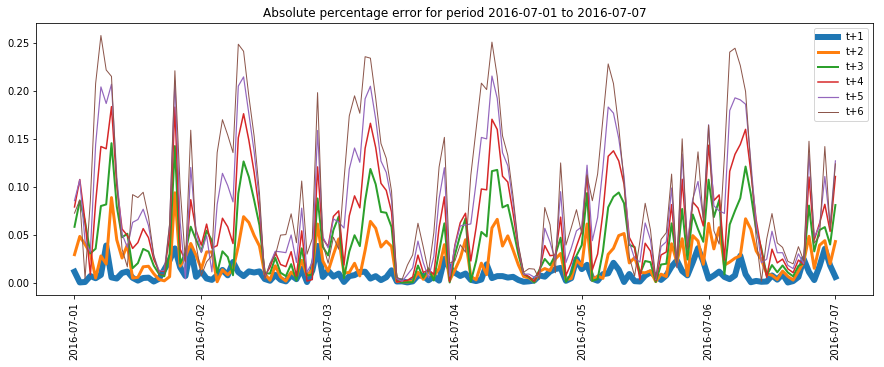

In [8]:
plt.figure(figsize=(15, 5))
for n in range(1,7,1):
    plt.plot(plot_df['timeStamp'], plot_df['abs_pct_error_t+'+str(n)], linewidth=6/n, label='t+'+str(n))
plt.xticks(rotation=90)
plt.title('Absolute percentage error for period ' + min_date + ' to ' + max_date)
plt.legend()
plt.show()

Notice how the forecast error gets progressively worse the greater the time difference between the forecasted period and the time the forecast was produced. This is due to the recursive method used to generate the forecasts causing the accumulation of errors.

### Inspect forecast errors over entire test dataset

This should reveal whether forecast error increases as time progresses. This could indicate that the model needs to be retrained more frequently so that the model can learn from more recent patterns in energy demand.

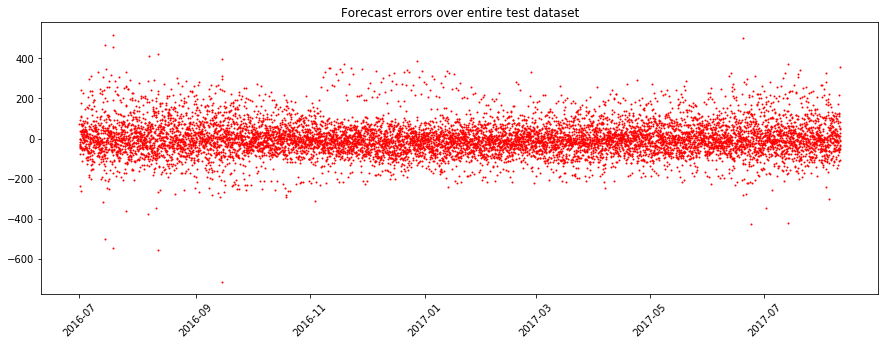

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(predictions['timeStamp'], predictions['error_t+1'], 'ro', markersize=1)
plt.title('Forecast errors over entire test dataset')
plt.xticks(rotation=45)
plt.show()

Now we can check if there are particular periods of time on which the model performs poorly:

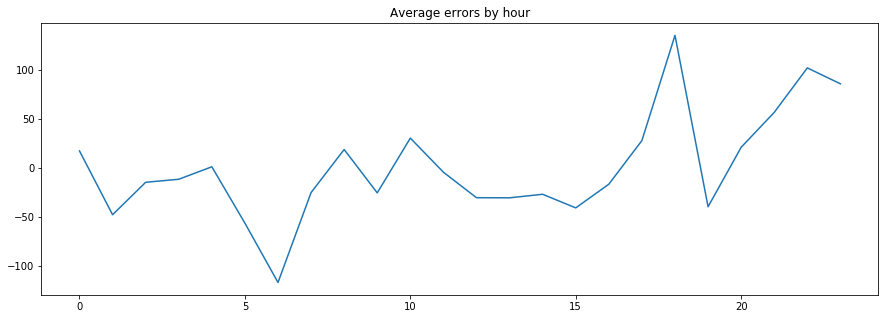

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(predictions[['hour', 'error_t+1']].groupby('hour').mean())
plt.title('Average errors by hour')
plt.show()

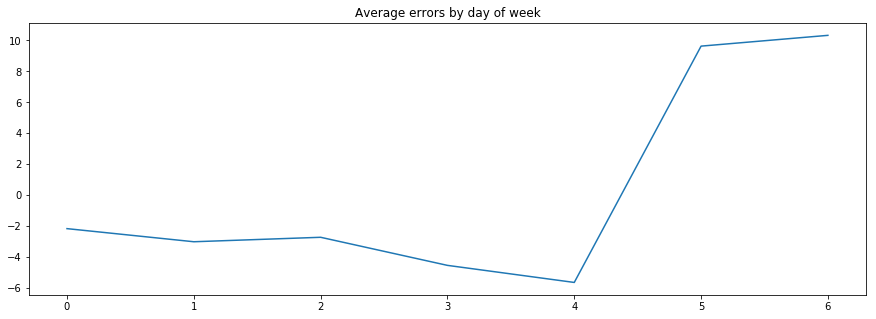

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(predictions[['dayofweek', 'error_t+1']].groupby('dayofweek').mean())
plt.title('Average errors by day of week')
plt.show()

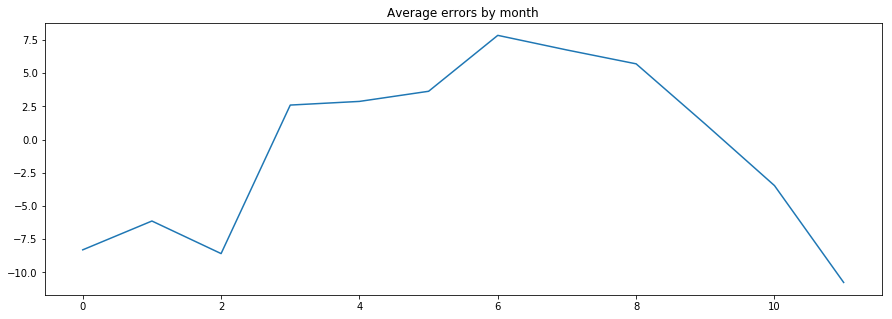

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(predictions[['month', 'error_t+1']].groupby('month').mean())
plt.title('Average errors by month')
plt.show()